In [1]:
print("hello world")

hello world


In [2]:
import sklearn

# 데이터 가져오기

In [3]:
from pathlib import Path
import pandas as pd
import tarfile
import urllib.request

def load_housing_data():
    tarball_path = Path("datasets/housing.tgz")#있어야 하는 파일의 경로

    if not tarball_path.is_file():#만약 아직 파일이 다운로드 되어 있지 않으면
        url = "https://github.com/ageron/data/raw/main/housing.tgz"
        urllib.request.urlretrieve(url, tarball_path)#지정된 경로로 다운로드

        with tarfile.open(tarball_path) as housing_tarball:#압축해제
            housing_tarball.extractall(path="datasets")

    return pd.read_csv(Path("datasets/housing/housing.csv"))#csv파일을 읽어왕서 pandas df로 감싼다.

housing = load_housing_data()

# 데이터 훑어보기

In [4]:
housing.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20640 entries, 0 to 20639
Data columns (total 10 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           20640 non-null  float64
 1   latitude            20640 non-null  float64
 2   housing_median_age  20640 non-null  float64
 3   total_rooms         20640 non-null  float64
 4   total_bedrooms      20433 non-null  float64
 5   population          20640 non-null  float64
 6   households          20640 non-null  float64
 7   median_income       20640 non-null  float64
 8   median_house_value  20640 non-null  float64
 9   ocean_proximity     20640 non-null  object 
dtypes: float64(9), object(1)
memory usage: 1.6+ MB


In [5]:
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [6]:
#ocean_proximity가 범주형 특성이라는 것을 알 수 있다.
housing["ocean_proximity"].value_counts()

ocean_proximity
<1H OCEAN     9136
INLAND        6551
NEAR OCEAN    2658
NEAR BAY      2290
ISLAND           5
Name: count, dtype: int64

In [7]:
housing.describe()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value
count,20640.000000,20640.000000,20640.000000,20640.000000,20433.000000,20640.000000,20640.000000,20640.000000,20640.000000
mean,-119.569704,35.631861,28.639486,2635.763081,537.870553,1425.476744,499.539680,3.870671,206855.816909
std,2.003532,2.135952,12.585558,2181.615252,421.385070,1132.462122,382.329753,1.899822,115395.615874
min,-124.350000,32.540000,1.000000,2.000000,1.000000,3.000000,1.000000,0.499900,14999.000000
25%,-121.800000,33.930000,18.000000,1447.750000,296.000000,787.000000,280.000000,2.563400,119600.000000
50%,-118.490000,34.260000,29.000000,2127.000000,435.000000,1166.000000,409.000000,3.534800,179700.000000
75%,-118.010000,37.710000,37.000000,3148.000000,647.000000,1725.000000,605.000000,4.743250,264725.000000
max,-114.310000,41.950000,52.000000,39320.000000,6445.000000,35682.000000,6082.000000,15.000100,500001.000000


array([[<Axes: title={'center': 'longitude'}>,
        <Axes: title={'center': 'latitude'}>,
        <Axes: title={'center': 'housing_median_age'}>],
       [<Axes: title={'center': 'total_rooms'}>,
        <Axes: title={'center': 'total_bedrooms'}>,
        <Axes: title={'center': 'population'}>],
       [<Axes: title={'center': 'households'}>,
        <Axes: title={'center': 'median_income'}>,
        <Axes: title={'center': 'median_house_value'}>]], dtype=object)

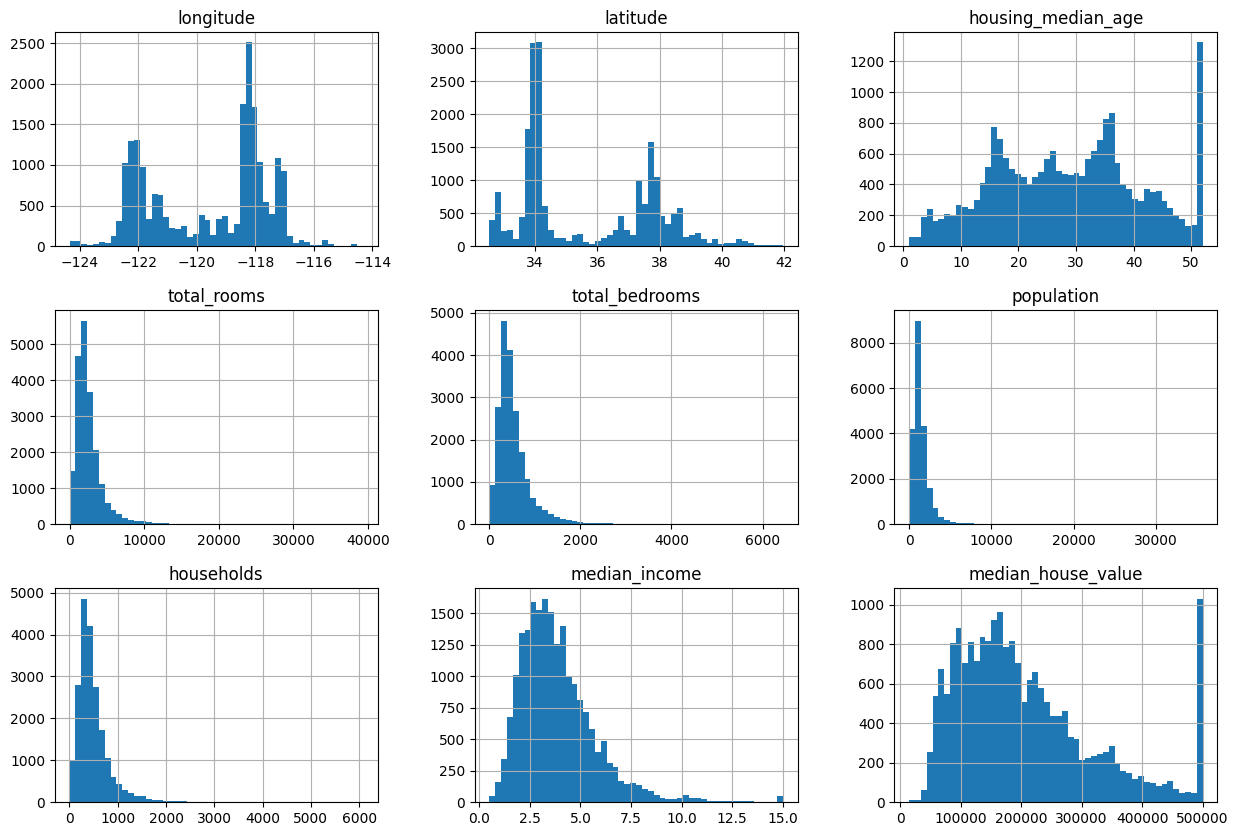

In [8]:
import matplotlib.pyplot as plt

#히스토그램을 그리는 데에는 이 코드면 충분하다.
housing.hist(bins=50, figsize=(15, 10))#bins는 막대의 수, fig_size는 그래프의 크기 지정

최대값이 제한되어 있는 특성들이 보임.
그리고 정규분포(가우스 분포)가 아니라 오른쪽 꼬리가 더 긴 모양을 띄고 있는 특성들이 보인다.
그리고 특성들마다 스케일이 달라서 나중에 스케일을 다 맞춰줘야 한다.

# 테스트 세트 생성하기 

그냥 무지성으로 뚝 짤라버리면 안되고, 테스트 세트가 전체 데이터를 잘 대변할 수 있도록 "계층적 샘플링"해줘야 한다.

In [9]:
import numpy as np

#pd.cut은 연속형 변수를 범주형 변수로 변환할 때 사용하는 pandas의 함수
housing["income_cat"] = pd.cut(housing["median_income"],
                               bins=[0.0, 1.5, 3.0, 4.5, 6., np.inf], #bins는 소득을 나눌 범위를 정한다. np.inf는 무한대를 의미하는 것. 6보다 큰 애들은 다 범주 5에 집어넣는 것이다. 
                               labels=[1, 2, 3, 4, 5])

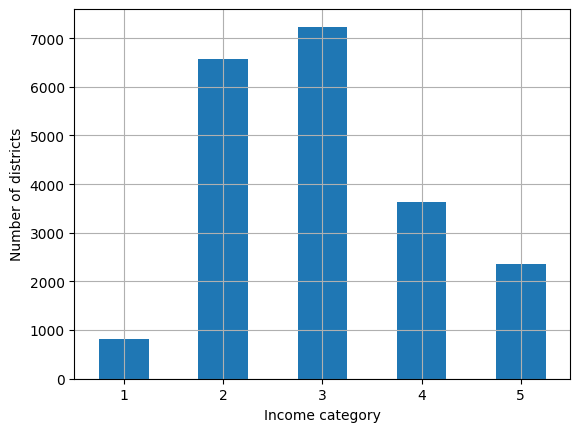

In [10]:
#value_counts()는 열에 있는 고유값의 수룰 계산한다.
#그리고 sort_index()로 범주를 오름차순으로 정렬
#plot()으로 내부적으로 matplotlib로 그래프를 그린다. bar는 막대그래프를 그리는 것임을 보여준다.
housing["income_cat"].value_counts().sort_index().plot.bar(rot=0, grid=True)
plt.xlabel("Income category")
plt.ylabel("Number of districts")
plt.show()

In [11]:
from sklearn.model_selection import train_test_split

#8:2 비율로 계층적 샘플링. 근데 vscodeㅅㅂ 매개변수 힌트 좀 주면 안되냐? 
train_set, test_set = train_test_split(housing, test_size=0.2, stratify=housing["income_cat"], random_state=42)

print(len(train_set)/len(housing))
print(len(test_set)/len(housing))

0.8
0.2


아래 막대 그래프를 보면 전체 데이터셋의 소득 비율과 똑같게 계층적으로 샘플링 된것을 확인할 수 있다.

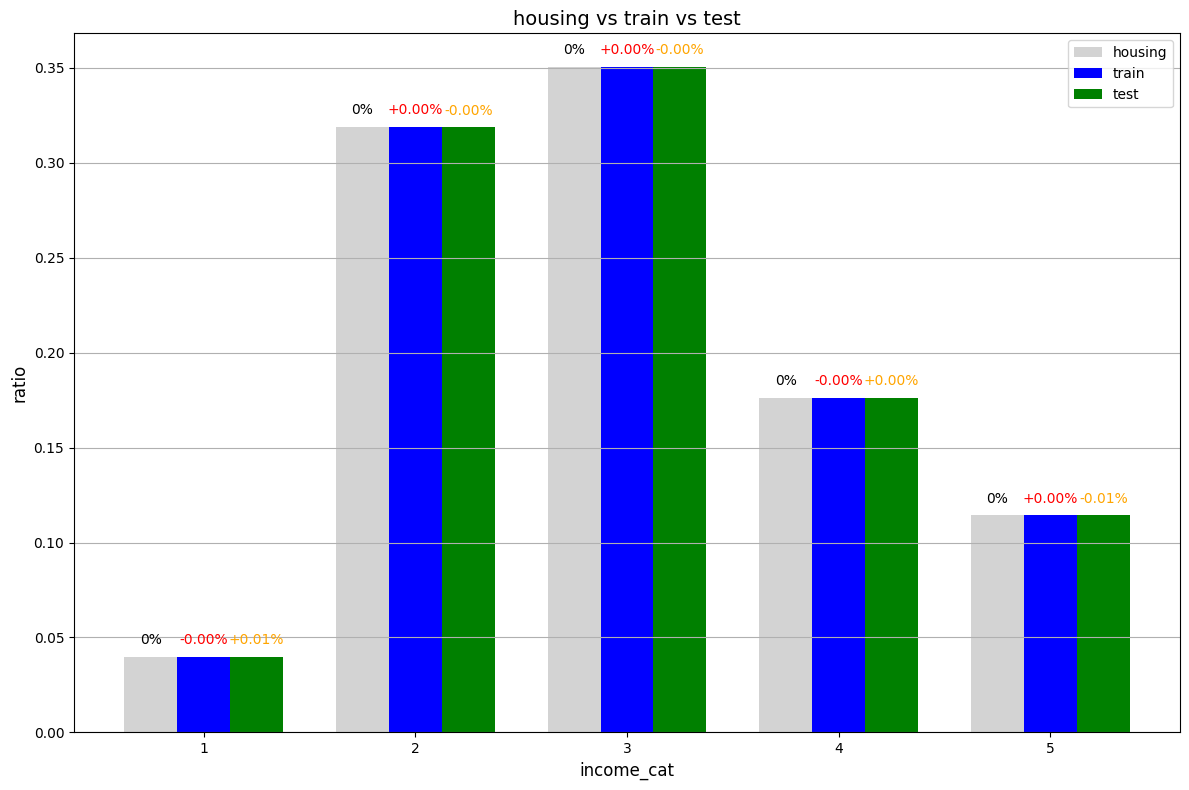

In [12]:
import numpy as np
import matplotlib.pyplot as plt

# 카테고리별 비율 계산
overall_counts = housing["income_cat"].value_counts(normalize=True).sort_index()
train_counts = train_set["income_cat"].value_counts(normalize=True).sort_index()
test_counts = test_set["income_cat"].value_counts(normalize=True).sort_index()

# 비율 오차 계산 (훈련 세트와 테스트 세트의 비율 - 전체 데이터셋 비율)
train_error = train_counts - overall_counts
test_error = test_counts - overall_counts

# 카테고리 순서 일치시키기
categories = overall_counts.index

# x축 위치 설정
x = np.arange(len(categories))
width = 0.25  # 막대 너비

fig, ax = plt.subplots(figsize=(12, 8))

# 전체 데이터셋의 막대 (회색)
ax.bar(x - width, overall_counts, width, label='housing', color='lightgray')

# 훈련 세트의 막대 (파란색)
ax.bar(x, train_counts, width, label='train', color='blue')

# 테스트 세트의 막대 (녹색)
ax.bar(x + width, test_counts, width, label='test', color='green')

# 각 막대 위에 비율 오차 표시
for i, cat in enumerate(categories):
    # 전체 데이터셋은 오차가 0%이므로 '0%' 표시
    ax.text(x[i] - width, overall_counts.iloc[i] + 0.005, '0%', ha='center', va='bottom', fontsize=10)
    
    # 훈련 세트 비율 오차 표시
    ax.text(x[i], train_counts.iloc[i] + 0.005, f"{train_error.iloc[i]:+.2%}", ha='center', va='bottom', color='red', fontsize=10)
    
    # 테스트 세트 비율 오차 표시
    ax.text(x[i] + width, test_counts.iloc[i] + 0.005, f"{test_error.iloc[i]:+.2%}", ha='center', va='bottom', color='orange', fontsize=10)

# 그래프 제목 및 축 레이블 설정
ax.set_xlabel('income_cat', fontsize=12)
ax.set_ylabel('ratio', fontsize=12)
ax.set_title('housing vs train vs test', fontsize=14)

# x축 눈금 설정
ax.set_xticks(x)
ax.set_xticklabels(categories)

# 범례 추가
ax.legend()

# y축 그리드 추가
ax.yaxis.grid(True)

# 레이아웃 조정 및 그래프 표시
plt.tight_layout()
plt.show()


In [13]:
#이제 더이상 쓸모없는 income_cat 속성은 제거한다. 이런 쓸데없는 특성이 들어가 있으면 별로 안좋음. 
for set_ in (train_set, test_set):
    set_.drop("income_cat", axis=1, inplace=True)

# 탐색과 시각화

그냥 대충 코드 정도만 쳐보고 넘어갑시다. 

In [14]:
housing = train_set.copy()

<Axes: xlabel='longitude', ylabel='latitude'>

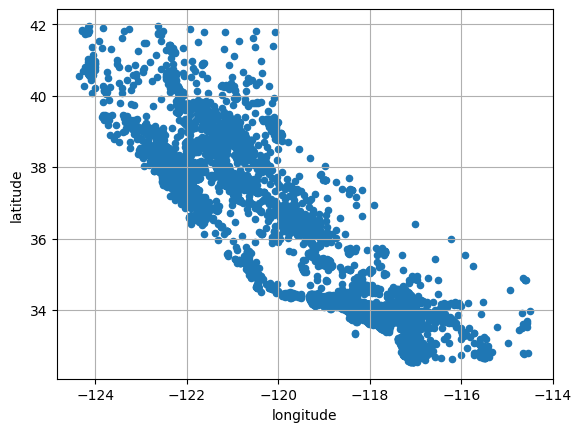

In [15]:
housing.plot(kind="scatter", x="longitude" ,y="latitude", grid=True)

<Axes: xlabel='longitude', ylabel='latitude'>

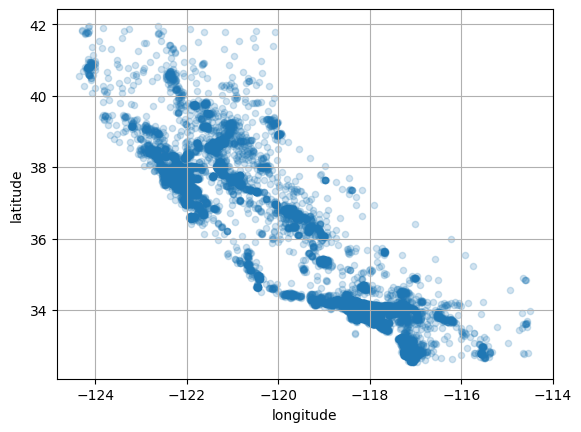

In [16]:
housing.plot(kind="scatter", x="longitude" ,y="latitude", grid=True, alpha = 0.2)

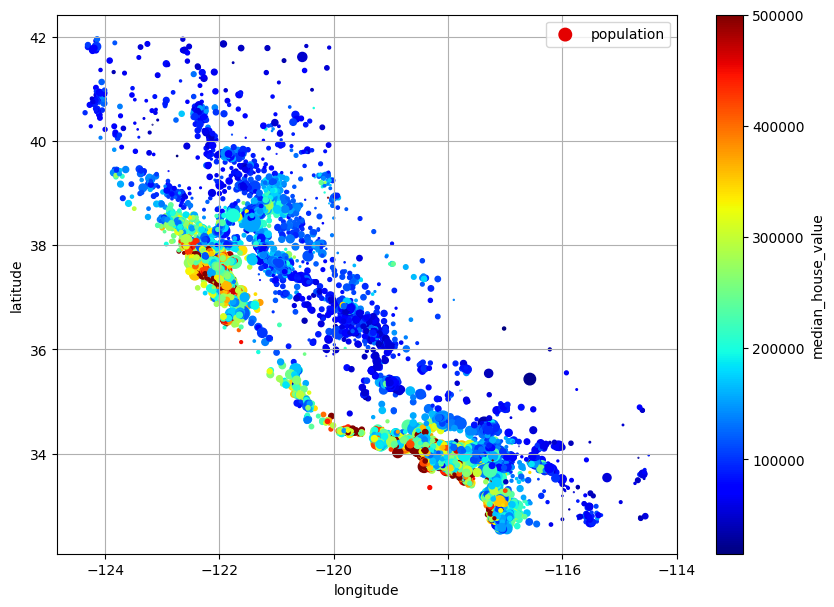

In [17]:
housing.plot(kind="scatter", x="longitude", y="latitude", grid=True,
             s=housing["population"] / 100, label="population",
             c="median_house_value", cmap="jet", colorbar=True,
             legend=True, figsize=(10, 7))
plt.show()

In [18]:
#표준 상관 계수 확인
corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

median_house_value    1.000000
median_income         0.688380
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
longitude            -0.050859
latitude             -0.139584
Name: median_house_value, dtype: float64

그냥 이런식으로 특성 조합을 실험하는 것이 좋다 정도만 봤고, 실제로 훈련 데이터에 이 특성조합을 적용하지는 않았음.

In [19]:
#특성 조합으로 실험, 새로 만든 특성들이 유용해보인다. 특히 rooms_per_house, bedrooms_ratio
housing["rooms_per_house"] = housing["total_rooms"] / housing["households"]
housing["bedrooms_ratio"] = housing["total_bedrooms"] / housing["total_rooms"]
housing["people_per_house"] = housing["population"] / housing["households"]

corr_matrix = housing.corr(numeric_only=True)
corr_matrix["median_house_value"].sort_values(ascending=False)

#housing.info()

median_house_value    1.000000
median_income         0.688380
rooms_per_house       0.143663
total_rooms           0.137455
housing_median_age    0.102175
households            0.071426
total_bedrooms        0.054635
population           -0.020153
people_per_house     -0.038224
longitude            -0.050859
latitude             -0.139584
bedrooms_ratio       -0.256397
Name: median_house_value, dtype: float64

# 데이터 준비

여기에서는 그냥 연습만 해보는거고, 실제 변환은 뒤에서 만든 파이프라인에서 이행될 것이다.
지금은 train_set을 함부로 건드리지 않아야 함.

## 먼저 수치형 특성부터

In [20]:
#먼저 훈련 데이터에서 레이블을 분리한다.
housing = train_set.drop("median_house_value", axis=1)
housing_label = train_set[["median_house_value"]]#시리즈가 아닌 df로 반환되게 함.

housing.info()
print("#########################################")
housing_label.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16344 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
 8   ocean_proximity     16512 non-null  object 
dtypes: float64(8), object(1)
memory usage: 1.3+ MB
#########################################
<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 1 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   median_house_value  16512 non-null  float64
dtypes

우선은 일부 샘플에서 total_bedrooms 특성이 null로 들어가 있는 부분을 고쳐줘야 한다. 여기에서는 중간값을 집어넣을 것이다.
이 작업을 위해서 사이킷런에서 제공하는 SimpleImputer를 사용할 것이다.

In [21]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")#빈 곳을 중위값으로 채울 것이다.
imputer.strategy

'median'

In [22]:
#중위값으로 채울 것이기 때문에 housing에서 수치형데이터만 뽑아줘야 한다. 범주형을 제외해야 함.
housing_num = housing.select_dtypes(include=[np.number])

In [23]:
imputer.fit(housing_num)#데이터에 맞춘다.
imputer.statistics_ #계산되어서 저장된 중위값을 확인할 수 있다. 

array([-118.51  ,   34.26  ,   29.    , 2125.    ,  434.    , 1167.    ,
        408.    ,    3.5385])

In [24]:
X = imputer.transform(housing_num)#변환
type(X)#넘파이 배열로 반환된다. 이걸 이제 다시 pandas df로 감싸줘야 함.

numpy.ndarray

In [25]:
housing_tr = pd.DataFrame(X, columns=housing_num.columns, index=housing_num.index)#다시 판다스 데이터 프레임으로 감싸준다. 
housing_tr.info()#이제 total_bedrooms 속성이 총 16512개가 있는 것을 확인할 수 있음.

<class 'pandas.core.frame.DataFrame'>
Index: 16512 entries, 13096 to 19888
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   longitude           16512 non-null  float64
 1   latitude            16512 non-null  float64
 2   housing_median_age  16512 non-null  float64
 3   total_rooms         16512 non-null  float64
 4   total_bedrooms      16512 non-null  float64
 5   population          16512 non-null  float64
 6   households          16512 non-null  float64
 7   median_income       16512 non-null  float64
dtypes: float64(8)
memory usage: 1.1 MB


아래 코드는 이상치를 삭제하는 코드이다.

이 코드는 housing_tr에서 이상치를 감지하고 제거하기 위해 IsolationForest를 사용합니다. contamination 매개변수는 데이터 세트의 이상치 비율을 추정하는 데 사용됩니다. fit 메서드는 모델을 훈련하는 데 사용되고, predict 메서드는 이상치를 예측하는 데 사용됩니다. outlier_predictions == 1는 정상치(이상치가 아닌 데이터)를 나타내며, 이를 사용하여 이상치가 제거된 housing_tr_cleaned와 housing_labels_cleaned를 얻습니다.

In [26]:
from sklearn.ensemble import IsolationForest

# IsolationForest 모델 생성
isolation_forest = IsolationForest(contamination=0.1)  # contamination은 데이터 세트에서 이상치의 비율을 추정

# 모델을 housing_tr에 훈련
isolation_forest.fit(housing_tr)


IsolationForest(contamination=0.1)

outlier_predictions는 IsolationForest 모델이 예측한 각 샘플의 이상치 여부를 나타내는 배열입니다. outlier_predictions의 각 요소는 housing_tr의 해당 인덱스 샘플에 대한 예측값을 담고 있습니다.

outlier_predictions[i]의 값이 -1이면, housing_tr의 i번째 샘플이 이상치라는 것을 의미합니다.
outlier_predictions[i]의 값이 1이면, housing_tr의 i번째 샘플이 정상치(inlier)라는 것을 의미합니다.

In [27]:
# 이상치 예측
outlier_predictions = isolation_forest.predict(housing_tr)
type(outlier_predictions)
print(outlier_predictions)


[-1  1  1 ...  1  1  1]


In [28]:
# 이상치가 아닌 데이터만 유지
housing_tr_cleaned = housing_tr[outlier_predictions == 1]
housing_label_cleaned = housing_label[outlier_predictions == 1]

## 이제 범주형 특성

In [29]:
housing_cat = housing[["ocean_proximity"]] #여기에서 housing_cat = housing["ocean_proximity"] 이렇게 하면 pd가 아니라 pandas.core.series.Series가 반환된다. 
housing_cat.value_counts()
type(housing_cat)

pandas.core.frame.DataFrame

이걸 이제 원-핫 인코딩으로 처리할거다.

In [30]:
from sklearn.preprocessing import OneHotEncoder

cat_encoder = OneHotEncoder()
housing_cat_1hot = cat_encoder.fit_transform(housing_cat)

#housing_cat_1hot.head() #원-핫 인코딩된 데이터 특성상 희소 배열이 반환되기 떄문에 head()를 사용할 수 없다. 

housing_cat_1hot.toarray() #toarray()를 써서 밀집 행렬로 바꿀 수 있다.

array([[0., 0., 0., 1., 0.],
       [1., 0., 0., 0., 0.],
       [0., 1., 0., 0., 0.],
       ...,
       [0., 0., 0., 0., 1.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 0., 1.]])

In [31]:
cat_encoder.categories_

[array(['<1H OCEAN', 'INLAND', 'ISLAND', 'NEAR BAY', 'NEAR OCEAN'],
       dtype=object)]

In [32]:
cat_encoder.feature_names_in_

array(['ocean_proximity'], dtype=object)

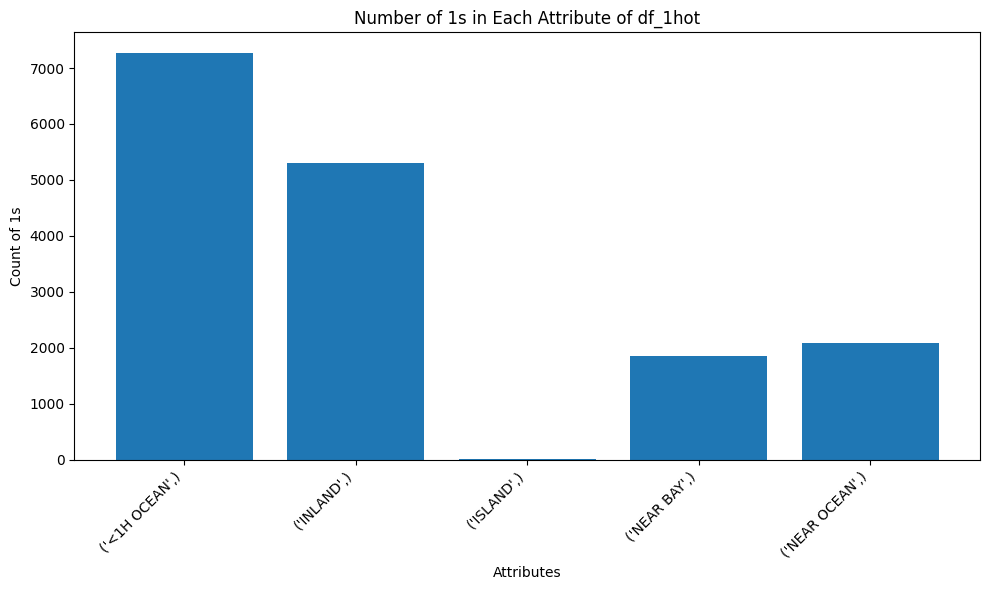

In [33]:
df_1hot = pd.DataFrame(housing_cat_1hot.toarray(), columns=cat_encoder.categories_, index=housing_cat.index)


# ddd의 각 열(속성)별로 값이 1인 항목의 개수를 계산합니다.
counts = (df_1hot == 1).sum()

# 막대 그래프를 그립니다.
plt.figure(figsize=(10, 6))  # 그래프 크기 설정

# counts.index가 MultiIndex이므로, 각 튜플을 문자열로 결합합니다.
plt.bar([str(i) for i in counts.index], counts.values)

plt.xlabel("Attributes")  # x축 레이블 설정
plt.ylabel("Count of 1s")  # y축 레이블 설정
plt.title("Number of 1s in Each Attribute of df_1hot")  # 그래프 제목 설정
plt.xticks(rotation=45, ha='right')  # x축 레이블 회전
plt.tight_layout()  # 레이아웃 조정
plt.show()  # 그래프 표시

## 스케일링

수치형 데이터에 스케일링을 적용한다. 먼저 오른쪽 꼬리가 긴 데이터에 로그 변환을 가해서 정규분포 모양으로 만들것이다.
그 후에 standarazation을 적용할 것이다. 이것도 그냥 연습이고, 실제 변환은 뒤에서 만들 파이프라인에서 적용될 것이다. 

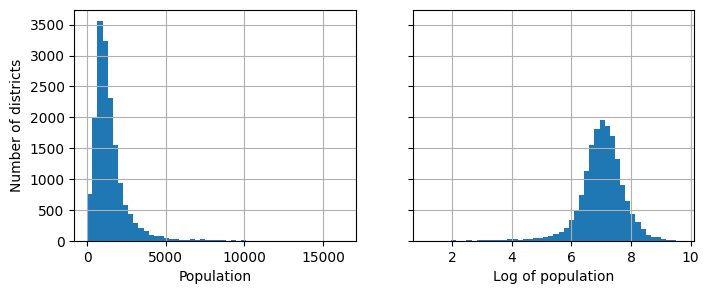

In [34]:
#로그 변환을 가해서 데이터를 정규 분포에 가까운 모양으로 변환시켰다.

fig, axs = plt.subplots(1, 2, figsize=(8, 3), sharey=True)
housing["population"].hist(ax=axs[0], bins=50)
housing["population"].apply(np.log).hist(ax=axs[1], bins=50)
axs[0].set_xlabel("Population")
axs[1].set_xlabel("Log of population")
axs[0].set_ylabel("Number of districts")
plt.show()

In [35]:
#실제로 로그 변환을 가함. 
housing["population"] = housing["population"].apply(np.log)

<Axes: >

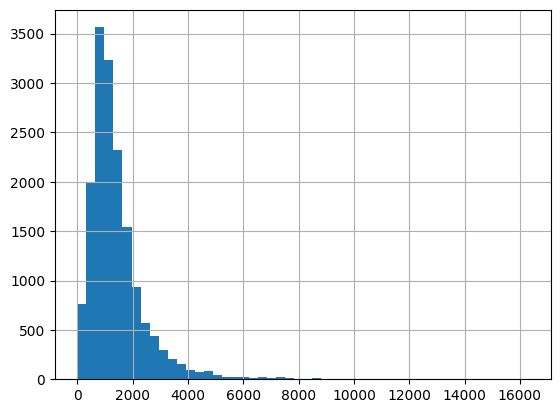

In [36]:
#다시 원래대로 되돌리기 위해서는 "지수함수"를 적용해서 로그 함수의 역변환을 가하면 된다.
housing["population"] = np.exp(housing["population"])
housing["population"].hist(bins=50)

polupation 속성 같은 경우에는 하나로 솥아 있지만, 그렇지 않고 멀티모드 분포 같은 경우도 있다. 이런 경우 버킷타이징을 사용하거나, 다른 유사도 특성을 추가하는 등의 방법을 책에서 소개함.

지금까지는 입력특성만 봤지만 **타깃값도 변환이 필요할 수 있다.** 예를 들어서 만약 타킷 분포의 꼬리가 두껍다면 타깃을 로그값으로 바꿀 수 있다. 하지만 이렇게 하면 회귀모델이 중간 주택 가격 자체가 아니라 그 로그를 예측하게 된다. 
중간 주택 가격을 얻고 싶다면 모델 예측에 지수 함수를 적용해야 한다. 

레이블에도 가공을 한 상태로 예측기를 훈련시킨 다음에, 예측값에 역연산을 가해서 예측을 얻어내는 간단한 예제를 하나 만들어보자.

In [37]:
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import StandardScaler

# 1. 특성(feature)과 레이블(label)을 위한 별도의 스케일러 생성
feature_scaler = StandardScaler()
label_scaler = StandardScaler()

# 2. 특성만 스케일링
scaled_features = feature_scaler.fit_transform(housing_tr_cleaned[["median_income"]])#np 배열이 반환된다. 그래서 여기에서 미리 필요한 특성만 뽑은 다음에 넣어주는 것이다.

# 3. 레이블 스케일링
scaled_label = label_scaler.fit_transform(housing_label_cleaned)

print(type(scaled_features))#StandardScaler를 통과하면 np 배열이 반환된다. 

# 4. 모델 훈련 (특성은 스케일링된 데이터, 레이블은 스케일링된 데이터)
model = LinearRegression()
model.fit(scaled_features, scaled_label)

# 5. 새로운 데이터: 특성 스케일러로만 변환
some_new_data = housing_tr_cleaned[["median_income"]].iloc[:5]
scaled_new_data = feature_scaler.transform(some_new_data)

# 6. 예측
predictions = model.predict(scaled_new_data)
print(predictions)

# 7. 역연산
revese_scaled_predictions = label_scaler.inverse_transform(predictions)
print(revese_scaled_predictions)


<class 'numpy.ndarray'>
[[ 0.89941926]
 [-0.53942928]
 [-0.60683225]
 [-0.10784559]
 [-0.17973683]]
[[306214.57136005]
 [143372.55967786]
 [135744.21392183]
 [192217.14272553]
 [184080.83469369]]


TransformedTargetRegressor를 사용하면 역연산을 자동으로 해줌.

In [38]:
from sklearn.compose import TransformedTargetRegressor

model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScaler())

model.fit(scaled_features, housing_label_cleaned)

predictions = model.predict(scaled_new_data)
print(predictions)

[[306214.57136005]
 [143372.55967786]
 [135744.21392183]
 [192217.14272553]
 [184080.83469369]]


# 사용자 지정 변환기

여기에서는 사용자 지정 변환기 코드를 작성하는 연습을 해보자.

사이킷런이 유용한 변환기를 많이 제공하지만 사용자 정의 변환, 정제 연산, 특성 결합과 같은 작업을 위해 자신만의 변환기를 작성할 필요가 있다.

**어떤 훈련도 필요하지 않은 변환의 경우** 넘파이 배열을 입력받고, 변환된 배열을 출력하는 함수를 작성하면 된다.

예를 들어서 오른쪽 꼬리가 두꺼운 것을 해결하는 로그 변환기를 만들어보자.

In [39]:
#변환이 필요하지 않은 경우 이렇게 간단하게 만들어주면 된다.
from sklearn.preprocessing import FunctionTransformer
   
log_transformer = FunctionTransformer(np.log, inverse_func=np.exp)
#inverse_func 매개변수는 선택사항이다. 예를 들어서 TransformedTargetRegressor에 이 변환기를 사용할 예정이라면 inverse_func매개변수에 역변환 함수를 지정할 수 있다.

아래와 같이 특성조합을 할 때 사용할 수도 있다. 아 그리고 사용할 때는 transform()함수를 사용한다. 

In [40]:
# X[:, [0]]: 모든 행(:)에서 첫 번째 열(0)을 선택합니다. 대괄호가 두 개([[0]]) 사용되었기 때문에 결과는 2차원 배열이 됩니다.
# X[:, [1]]: 모든 행(:)에서 두 번째 열(1)을 선택합니다. 역시 대괄호가 두 개([[1]]) 사용되어 2차원 배열이 됩니다.
ratio_transformer = FunctionTransformer(lambda X : X[:,[0]] / X[:,[1]])

ratio_transformer.transform(np.array([[1., 2.],[3., 4.]]))

array([[0.5 ],
       [0.75]])

그런데 **fit()메서드로 특정 파라미터를 학습하고 나중에 transform()메서드로 이를 사용하기 위해 훈련 가능한 변환기가 필요하다면** 어떻게 해야할까? 이렇게 하려면 사용자 정의 클래스를 작성해야 한다.

사이킷런은 덕 타이핑()에 의존하기 때문에 특정 클래스를 상속할 필요는 없다. 필요한 것은 `fit()`,`transform()`,`fit_transform()` 이렇게 세 개의 메서드이다.

책의 내용을 참고해서 거의 완벽하게 inverse_transform()과 get_feature_names_out까지 작성했다.

In [41]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_array, check_is_fitted
#sklearn.utils.validation에는 여러가지 검증 메서드들이 있다고 함.

#TransformerMixin을 상속하면 fit_transform()메서드를 자동으로 얻는다. 그냥 fit(), transform()을 연달아서 호출함.
#BaseEstimator를 상속하고 생성자함수에 *args나 **kwargs를 사용하지 않으면 하이퍼파라미터 튜닝에 필요한 두 메서드 get_params()와 set_params()를 추가로 얻게 된다.

class StandardScalerClone(BaseEstimator, TransformerMixin):
    def __init__(self, with_mean=True):
        self.with_mean = with_mean

    def fit(self, X, y=None):#사용하지 않더라도 y를 넣어주어야 함.
        X_original = X #check_array()를 통과하면 NumPy배열로 바뀌기 때문에 이렇게 복사해놓는 것. get_feature_names_out()을 위해 필요하다. 
        
        X = check_array(X) #X가 부동소수점 배열인지 확인, 유효성 검사을 검사하고 NumPy배열로 반환한다. 그래서 fit(), transform()은 df와 np배열 모두 입력으로 받을 수 있다. 
        
        #표준화 연산을 위해 입력 데이터의 평균과 표준편차를 얻음.
        self.mean_ = X.mean(axis=0)
        self.scale_ = X.std(axis=0)
        self.n_features_in_ = X.shape[1]#입력 데이터의 특성 수

        if isinstance(X_original, pd.DataFrame):#입력이 데이터프레임이라면
            self.feature_names_in_ = np.array(X_original.columns, dtype=object)

        return self
    
    def transform(self, X):
        check_is_fitted(self) #훈련으로 학습된 속성이 있는지 확인, 쉽게 말해 학습이 완료되었는지 확인

        X = check_array(X)

        #assert 문은 코드에서 특정 조건이 참인지 확인하는 데 사용되는 디버깅 도구입니다. assert 뒤에 오는 조건이 거짓이면 AssertionError 예외가 발생합니다.
        #n_features_in_은 모델이 훈련된 특성의 개수를 나타내고, X.shape[1]은 입력 배열 X의 열 개수, 즉 특성의 개수를 나타냅니다.
        #이 assert 문은 transform 메서드에 전달된 입력 배열 X가 모델이 훈련된 데이터와 동일한 개수의 특성을 가지고 있는지 확인하는 데 사용됩니다.
        assert self.n_features_in_ == X.shape[1] 

        if self.with_mean:
            X = X - self.mean_
        return X / self.scale_
    
    #위 구현은 완벽한 구현이 아니다. inverse_transform(), get_feature_names_out()함수가 있어야 함. 

    def inverse_transform(self, X):
        check_is_fitted(self)

        X = check_array(X)

        assert self.n_features_in_ == X.shape[1] 

        #표준화 연산의 역연산을 수행해서 반환한다.
        X = X * self.scale_
        
        # 평균을 더함 (with_mean이 True인 경우)
        if self.with_mean:
            X = X + self.mean_
        
        return X
    
    def get_feature_names_out(self, input_features=None):
        # 1. input_features가 None인 경우:
        # self 객체에 feature_names_in_ 속성이 있는지 확인합니다.
        # feature_names_in_ 속성이 있으면 그 값을 반환합니다.
        # feature_names_in_ 속성이 없으면 x0, x1, x2 등과 같이 self.n_features_in_ (특성 개수)를 기반으로 생성된 기본 특성 이름 리스트를 반환합니다.

        # 2. input_features가 None이 아닌 경우 (즉, 입력 특성 이름이 제공된 경우):
        # 입력 특성의 개수(len(input_features))가 self.n_features_in_과 같은지 확인합니다.
        # self 객체에 feature_names_in_ 속성이 있는지 확인하고, 이 속성이 input_features와 일치하는지 확인합니다.
        # 위의 두 조건 중 하나라도 만족하지 않으면 ValueError를 발생시킵니다.
        # 두 조건이 모두 만족하면 입력된 input_features를 그대로 반환합니다.

        if input_features is None:
            return getattr(self, "feature_names_in_",
                           [f"x{i}" for i in range(self.n_features_in_)])
        else:
            if len(input_features) != self.n_features_in_:
                raise ValueError("Invalid number of features")
            if hasattr(self, "feature_names_in_") and not np.all(
                self.feature_names_in_ == input_features
            ):
                raise ValueError("input_features ≠ feature_names_in_")
            return input_features

내가 작성한 StandaedScalerClone을 사용해보면 잘 작동하는 것을 확인할 수 있다.

In [42]:
tr = StandardScalerClone()

tr.fit(housing_tr_cleaned)
print(tr.get_feature_names_out())

['longitude' 'latitude' 'housing_median_age' 'total_rooms'
 'total_bedrooms' 'population' 'households' 'median_income']


In [43]:
model = TransformedTargetRegressor(LinearRegression(), transformer=StandardScalerClone())

model.fit(scaled_features, housing_label_cleaned)

predictions = model.predict(scaled_new_data)
print(predictions)


[[306214.57136005]
 [143372.55967786]
 [135744.21392183]
 [192217.14272553]
 [184080.83469369]]


## 파이프라인

파이프 라인 만드는 연습만 간단하게 하고 넘어가자.

우선 Pipeline 클래스를 이용해서 만들 수도 있다. 
이름은 이중 밑줄 문자`__`를 포함하지 않으면서 고유하다면 어떤 것도 가능하다. **이중 밑줄 문자는 나중에 하이퍼파라미터 튜닝에 사용**된다.
**추정기는 마지막을 제외하고 모두 변환기여야 한다.** 즉 fit_transform()메서드를 가져야 한다는 것이다.
마지막 추정기는 변환기, 예측기부터 다른 타입의 추정기까지 무엇이든 가능하다.

In [44]:
#매개변수로 연속적인 단계를 정의하는 이름/추정기 쌍의 튜플로 이루어진 리스트를 받는다. 

from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standarize", StandardScaler())
])

In [45]:
#파이프라인을 시각화
from sklearn import set_config
set_config(display="diagram")
num_pipeline

Pipeline(steps=[('impute', SimpleImputer(strategy='median')),
                ('standarize', StandardScaler())])

변환기의 이름을 일일이 짓는게 귀찮다면 make_pipeline()함수를 사용해도 된다.
참고로 파이프라인 객체는 마지막 추정기와 동일한 메서드를 제공한다.

마지막 추정기가 변환기가 아니라 예측기라면 predict()메서드를 제공함. 

In [46]:
from sklearn.pipeline import make_pipeline
num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())

from sklearn import set_config
set_config(display="diagram")
num_pipeline

Pipeline(steps=[('simpleimputer', SimpleImputer(strategy='median')),
                ('standardscaler', StandardScaler())])

파이프라인의 출력은 일반적으로 넘파이 배열이다. 필요하면 `get_feature_names_out()`메서드를 사용해서 df로 재구성 하면 된다.

그리고 파이프라인은 인덱싱을 지원한다.

In [47]:
num_pipeline[0]

SimpleImputer(strategy='median')

## ColumnTransformer

ColumnTransformer는 데이터의 특성 특성에 맞는 파이프라인을 개별적으로 적용할 수 있게 해준다. 

In [48]:
#어떤걸 넣어줘야 하는지 헷갈릴 때는 그냥 라이브러리에서 제공해주는 설명을 잘 보자.

from sklearn.compose import ColumnTransformer

num_attribs = ["longitude", "latitude", "housing_median_age", "total_rooms",
               "total_bedrooms", "population", "households", "median_income"]#수치형 특성
cat_attribs = ["ocean_proximity"]#범주형 특성

num_pipeline = make_pipeline(SimpleImputer(strategy='median'), StandardScaler())
cat_pipeline = make_pipeline(SimpleImputer(strategy='most_frequent'), OneHotEncoder())

preprocessing = ColumnTransformer([
    ("num",num_pipeline,num_attribs),#수치형 특성에는 num_pipeline 적용
    ("cat",cat_pipeline,cat_attribs)#범주형 특성에는 cat_pipeline 적용
])

preprocessing.fit_transform(housing)[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94,  0.  ,
         0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ]])

더 간단하게 만들 수 있는 방법도 있다. 

In [49]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number)),
    (cat_pipeline, make_column_selector(dtype_include=object))
)

preprocessing.fit_transform(housing)[:2].round(2)

array([[-1.42,  1.01,  1.86,  0.31,  1.37,  0.14,  1.39, -0.94,  0.  ,
         0.  ,  0.  ,  1.  ,  0.  ],
       [ 0.6 , -0.7 ,  0.91, -0.31, -0.44, -0.69, -0.37,  1.17,  1.  ,
         0.  ,  0.  ,  0.  ,  0.  ]])

# 최종 파이프라인 작성

필요한 것들을 정리해보자.

**수치형 특성**
1. 만약에 null로 지정되어 있으면 중간값으로 채워줘야 한다.
2. 오른쪽 꼬리가 긴 데이터들에 로그 변환을 가해서 정규분포 모양으로 만들어줘야 한다. 
["total_bedrooms", "total_rooms", "population", "households", "median_income"]
3. 특성조합해서 유용한 특성 만들어서 추가하기
4. 수치형 특성들에 모두 표준화를 가해서 스케일을 비슷하게 만들어줘야 한다. 
5. 좌표를 기준으로 클러스터와의 유사도 측정 값
이상치 제거는 그냥 뺌....

**범주형 특성**
1. 원-핫 인코딩

### default_num_pipeline
가장 기본적인 수치형 데이터 파이프라인

null값을 중간값으로 채우고, 표준화한다.

In [50]:
default_num_pipeline = make_pipeline(SimpleImputer(strategy="median"), StandardScaler())

### ratio_pipeline
특성들을 조합해서 유용한 특성을 만드는 파이프라인

null값을 중간값으로 채우고, 두 특성의 비율을 계산해서 반환하고(새로운 특성), 표준화한다.

In [51]:
def ratio_name(function_transformer, feature_names_in):
    return ["ratio"]  # get_feature_names_out에 사용

column_ratio = lambda X : X[:,[0]] / X[:,[1]]
column_ratio_transformer = FunctionTransformer(column_ratio, feature_names_out=ratio_name)

ratio_pipeline = make_pipeline(SimpleImputer(strategy="median"), column_ratio_transformer, StandardScaler())

### log_pipeline 
오른쪽 꼬리가 긴 데이터들에 로그변환을 가한다.

null값을 중간값으로 채우고, 로그변환을 가하고, 표준화한다.

In [52]:
log_transformer = FunctionTransformer(np.log, feature_names_out="one-to-one")#one-to-one인 경우 입력된 특성의 이름을 그대로 내보낸다.

log_pipeline = make_pipeline(SimpleImputer(strategy="median"), log_transformer, StandardScaler())

### cluster_simil_pipeline
입력된 데이터에서 클러스터를 찾아내고, 각 샘플의 좌표와 클러스터들의 좌표가 얼마나 유사한지 계산한다.

데이터셋의 위도,경도를 입력할 것이다.

In [53]:
from sklearn.cluster import KMeans
from sklearn.metrics.pairwise import rbf_kernel

class ClusterSimilarity(BaseEstimator, TransformerMixin):
    def __init__(self, n_clusters=10, gamma=1.0, random_state=None):
        self.n_clusters = n_clusters
        self.gamma = gamma
        self.random_state = random_state

    def fit(self, X, y=None, sample_weight=None):
        # 사이킷런 1.2버전에서 최상의 결과를 찾기 위해 반복하는 횟수를 지정하는 `n_init` 매개변수 값에 `'auto'`가 추가되었습니다.
        # `n_init='auto'`로 지정하면 초기화 방법을 지정하는 `init='random'`일 때 10, `init='k-means++'`일 때 1이 됩니다.
        # 사이킷런 1.4버전에서 `n_init`의 기본값이 10에서 `'auto'`로 바뀝니다. 경고를 피하기 위해 `n_init=10`으로 지정합니다.

        self.kmeans_ = KMeans(self.n_clusters, n_init=10, random_state=self.random_state)
        self.kmeans_.fit(X, sample_weight=sample_weight)#확률적인 알고리즘으로 입력 데이터에서 클러스터를 찾아낸다. 비지도 학습
        return self  # 항상 self를 반환합니다!

    def transform(self, X):
        return rbf_kernel(X, self.kmeans_.cluster_centers_, gamma=self.gamma)

    def get_feature_names_out(self, names=None): #뒤에서 출력되는 모습을 확인할 수 있다.
        return [f"클러스터 {i} 유사도" for i in range(self.n_clusters)]
    
cluster_simil_pipeline = ClusterSimilarity(n_clusters=10, gamma=1., random_state=42)

### cat_pipeline
범주형 특성들을 원-핫 인코딩한다.

null값을 최빈값으로 채우고, 원-핫 인코딩한다.

In [54]:
cat_pipeline = make_pipeline(SimpleImputer(strategy="most_frequent"), OneHotEncoder())

### 최종 데이터 가공 파이프라인

In [55]:
preprocessing = ColumnTransformer([
    ("rooms_per_house", ratio_pipeline, ["total_rooms", "households"]),
    ("bedrooms", ratio_pipeline, ["total_bedrooms", "total_rooms"]),#방과 침실의 비율
    ("log", log_pipeline, ["total_bedrooms", "total_rooms", "population", "households", "median_income"]),
    ("geo", cluster_simil_pipeline, ["longitude", "latitude"]),
    ("cat", cat_pipeline, make_column_selector(dtype_include=object))
], remainder=default_num_pipeline)

이제 train_set, test_set에서 데이터와 레이블을 분리하자.

In [56]:
train_set_label = train_set[["median_house_value"]]
train_set = train_set.drop("median_house_value", axis=1)

test_set_label = test_set[["median_house_value"]]
test_set = test_set.drop("median_house_value", axis=1)

preprocessing 파이프라인을 테스트 해보자.

In [57]:
preprocessed = preprocessing.fit_transform(train_set)

print(preprocessing.get_feature_names_out())
print(preprocessed.shape)


['rooms_per_house__ratio' 'bedrooms__ratio' 'log__total_bedrooms'
 'log__total_rooms' 'log__population' 'log__households'
 'log__median_income' 'geo__클러스터 0 유사도' 'geo__클러스터 1 유사도'
 'geo__클러스터 2 유사도' 'geo__클러스터 3 유사도' 'geo__클러스터 4 유사도' 'geo__클러스터 5 유사도'
 'geo__클러스터 6 유사도' 'geo__클러스터 7 유사도' 'geo__클러스터 8 유사도' 'geo__클러스터 9 유사도'
 'cat__ocean_proximity_<1H OCEAN' 'cat__ocean_proximity_INLAND'
 'cat__ocean_proximity_ISLAND' 'cat__ocean_proximity_NEAR BAY'
 'cat__ocean_proximity_NEAR OCEAN' 'remainder__housing_median_age']
(16512, 23)


# 모델 선택과 훈련

간단한 선형회귀 모델을 훈련시켜본다.

In [58]:
linear_regression_model = make_pipeline(preprocessing, LinearRegression())
linear_regression_model.fit(train_set, train_set_label)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('rooms_per_house',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name...
                                                   'total_rooms', 'population',
                                                   'households',
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['longitude', 'latitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16d2fe6d0>)])),
                ('linearregression', LinearRegression())])

이번에는 랜덤 포레스트로 훈련시켜본다.

In [59]:
from sklearn.ensemble import RandomForestRegressor

random_forest_model = make_pipeline(preprocessing, RandomForestRegressor(max_depth=15, random_state=42))
random_forest_model.fit(train_set, train_set_label)

/Users/barrett11357/coding/handson_ml_--/.venv/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


Pipeline(steps=[('columntransformer',
                 ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                              SimpleImputer(strategy='median')),
                                                             ('standardscaler',
                                                              StandardScaler())]),
                                   transformers=[('rooms_per_house',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('functiontransformer',
                                                                   FunctionTransformer(feature_names_out=<function ratio_name...
                                                   'median_income']),
                                                 ('geo',
                                                  ClusterSimilarity(random_state=42),
                                                  ['longitude', 'latitude']),
                                                 ('cat',
                                                  Pipeline(steps=[('simpleimputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehotencoder',
                                                                   OneHotEncoder())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x16d2fe6d0>)])),
                ('randomforestregressor',
                 RandomForestRegressor(max_depth=15, random_state=42))])

훈련 데이터, 테스트 데이터의 RMSE를 비교하면서 모델의 성능이 어떤지, 과적합 되지는 않았는지 평가할 것이다.

In [60]:
linear_regression_model_train_predictions = linear_regression_model.predict(train_set)
random_forest_model_train_predictions = random_forest_model.predict(train_set)

linear_regression_model_test_predictions = linear_regression_model.predict(test_set)
random_forest_model_test_predictions = random_forest_model.predict(test_set)

In [61]:
from sklearn.metrics import mean_squared_error

# predictions는 모델의 예측값 배열, labels는 실제 레이블 배열
def calculate_rmse(label, predictions):
    mse = mean_squared_error(label, predictions)
    rmse = np.sqrt(mse)

    print(f"RMSE: {rmse}")
    return rmse

아래 두개는 선형 회귀 모델의 훈련, 데스트 데이터 RMSE

In [62]:
# predictions는 모델의 예측값 배열, labels는 실제 레이블 배열
calculate_rmse(train_set_label, linear_regression_model_train_predictions)

RMSE: 69064.0234776665


np.float64(69064.0234776665)

In [63]:
# predictions는 모델의 예측값 배열, labels는 실제 레이블 배열
calculate_rmse(test_set_label, linear_regression_model_test_predictions)

RMSE: 70938.47514001527


np.float64(70938.47514001527)

아래 두개는 랜덤 포레스트 회귀 모델의 훈련, 테스트 데이터 RMSE

In [64]:
# predictions는 모델의 예측값 배열, labels는 실제 레이블 배열
calculate_rmse(train_set_label, random_forest_model_train_predictions)

RMSE: 24958.979825125607


np.float64(24958.979825125607)

In [65]:
# predictions는 모델의 예측값 배열, labels는 실제 레이블 배열
calculate_rmse(test_set_label, random_forest_model_test_predictions)

RMSE: 48538.764872679065


np.float64(48538.764872679065)

위의 선형회귀 모델은 너무 약하고(과소적합), 랜덤 포레스트 회귀 모델은 과적합 되어있음.

# 모델 미세 튜닝

선형 회귀는 갖다 버리고, 랜덤 포레스트 회귀 모델의 하이퍼 파라미터를 조정해보자.

## 그리드 서치

In [67]:
from sklearn.model_selection import GridSearchCV

full_pipeline = Pipeline([
    ("preprocessing", preprocessing),
    ("random_forest", RandomForestRegressor(random_state=42)),
])
param_grid = [
    {'preprocessing__geo__n_clusters': [5, 8, 10],
     'random_forest__max_features': [4, 6, 8]},
    {'preprocessing__geo__n_clusters': [10, 15],
     'random_forest__max_features': [6, 8, 10]},
]
grid_search = GridSearchCV(full_pipeline, param_grid, cv=3, scoring='neg_root_mean_squared_error')
grid_search.fit(train_set, train_set_label)

/Users/barrett11357/coding/handson_ml_--/.venv/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/barrett11357/coding/handson_ml_--/.venv/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/barrett11357/coding/handson_ml_--/.venv/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)
/Users/barrett11357/coding/handson_ml_--/.venv/lib/python3.9/site-packages/sklearn/base.py:1389: Dat

GridSearchCV(cv=3,
             estimator=Pipeline(steps=[('preprocessing',
                                        ColumnTransformer(remainder=Pipeline(steps=[('simpleimputer',
                                                                                     SimpleImputer(strategy='median')),
                                                                                    ('standardscaler',
                                                                                     StandardScaler())]),
                                                          transformers=[('rooms_per_house',
                                                                         Pipeline(steps=[('simpleimputer',
                                                                                          SimpleImputer(strategy='median')),
                                                                                         ('functiontransformer',
                                                                                          FunctionTransformer(feature_names...
                                                                         <sklearn.compose._column_transformer.make_column_selector object at 0x16d2fe6d0>)])),
                                       ('random_forest',
                                        RandomForestRegressor(random_state=42))]),
             param_grid=[{'preprocessing__geo__n_clusters': [5, 8, 10],
                          'random_forest__max_features': [4, 6, 8]},
                         {'preprocessing__geo__n_clusters': [10, 15],
                          'random_forest__max_features': [6, 8, 10]}],
             scoring='neg_root_mean_squared_error')

In [68]:
grid_search.best_params_

{'preprocessing__geo__n_clusters': 15, 'random_forest__max_features': 6}

RMSE가 감소했다 얏호!!!

In [71]:
best_random_forest_model = grid_search.best_estimator_ #최상의 하이퍼파라미터로 세팅된 모델을 반환

best_random_forest_model.fit(train_set, train_set_label)

best_random_forest_model_train_predictions = best_random_forest_model.predict(train_set)
calculate_rmse(train_set_label, best_random_forest_model_train_predictions)

best_random_forest_model_test_predictions = best_random_forest_model.predict(test_set)
calculate_rmse(test_set_label, best_random_forest_model_test_predictions)

/Users/barrett11357/coding/handson_ml_--/.venv/lib/python3.9/site-packages/sklearn/base.py:1389: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  return fit_method(estimator, *args, **kwargs)


RMSE: 16058.071234866145
RMSE: 43462.50714563421


np.float64(43462.50714563421)

grid_search.cv_results_ 를 통해서 자세한 평가 점수도 얻을 수 있다.

In [75]:
cv_res = pd.DataFrame(grid_search.cv_results_)
cv_res.sort_values(by="mean_test_score", ascending=False, inplace=True)

# 추가 코드 – 데이터프레임을 깔끔하게 출력하기 위한 코드입니다
cv_res = cv_res[["param_preprocessing__geo__n_clusters",
                 "param_random_forest__max_features", "split0_test_score",
                 "split1_test_score", "split2_test_score", "mean_test_score"]]
score_cols = ["split0", "split1", "split2", "mean_test_rmse"]
cv_res.columns = ["n_clusters", "max_features"] + score_cols
cv_res[score_cols] = -cv_res[score_cols].round().astype(np.int64)

cv_res.head()

,n_clusters,max_features,split0,split1,split2,mean_test_rmse
12,15,6,44139,44695,45086,44640
13,15,8,44311,44978,45354,44881
14,15,10,44846,45411,45500,45252
6,10,4,44730,45281,45991,45334
7,10,6,45337,45725,46112,45724
